# Performance Analysis of the models

In the course of this project we considered two main models of clustering:

- As basic model, we considered **K-means** clustering

- As non-trivial model, we considered **DBScan** clustering

The performances of these models in the pursuit of reconstructing the missing data within 3 features varied, with a surprisingly better result coming from our basic model. We make these observations clear within our team in 2 stages:

## Stage 1: Viewing results

The end reconstructions of our team are as follows:

Alex reconstructed the data using K-means, which resulted in this:
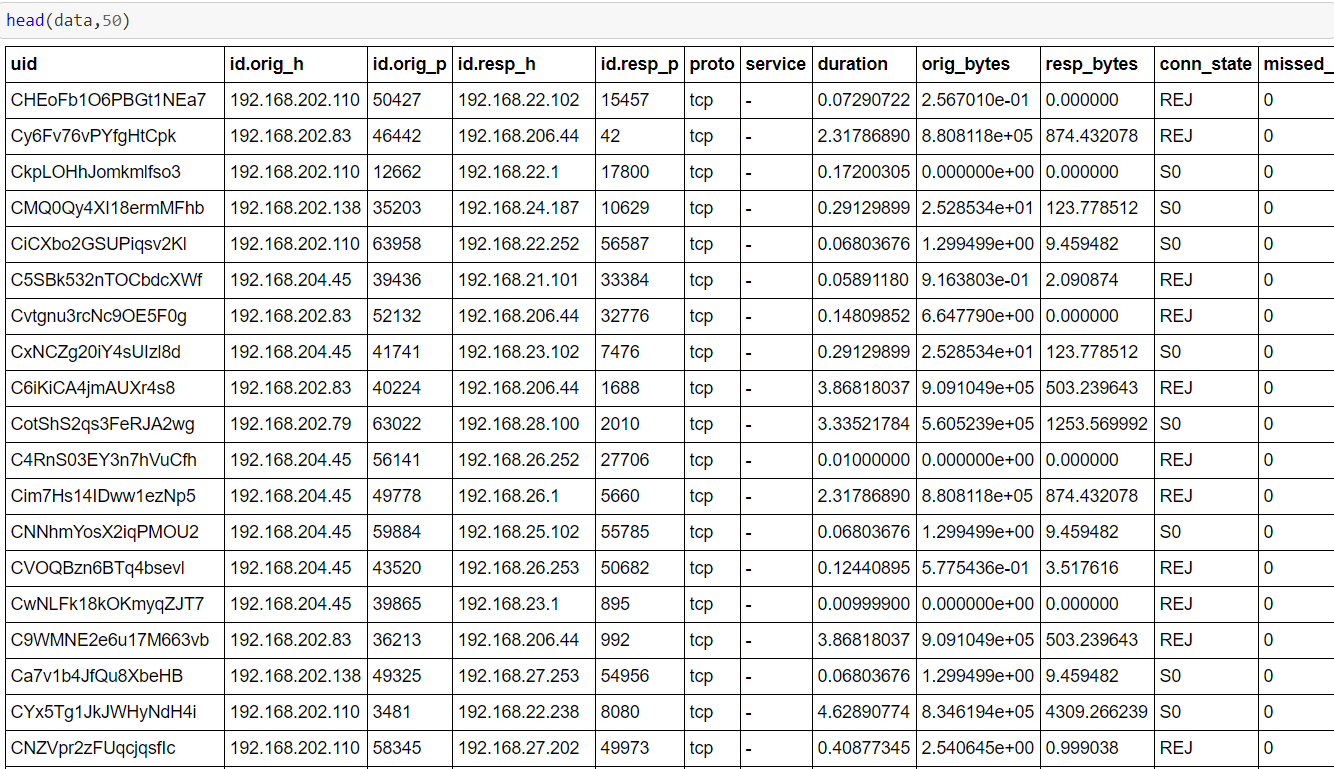

From a first view, the results seem to match the visual pattern of duration-orig_bytes-resp_bytes distribution pre-existent in the data, to some notable degree. 

Matt and Wenqi reconstructed the data using DBScan, which resulted in this:



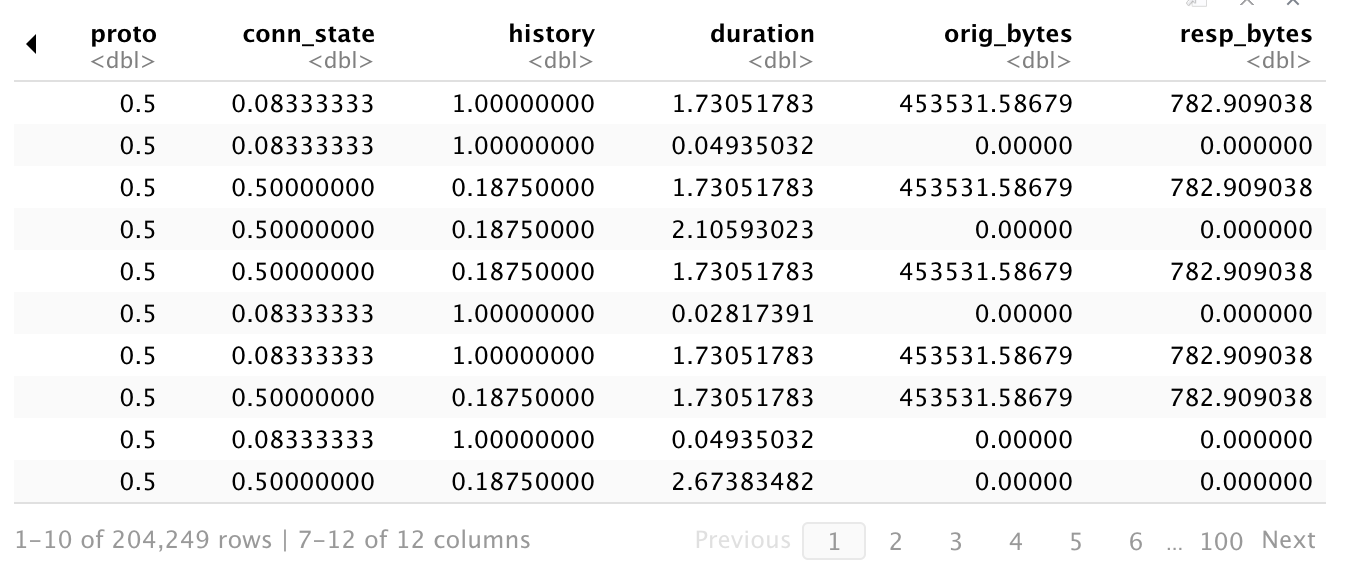

The duration seems to have been well reconstructed, as to retain similar values to the datapoints already existing in the column. The orig_bytes and resp_bytes, however, seem to have been aggressively segregated by DBScan - in the sense that outliers have seemingly been assigned their own clusters and occupy most of it, whereas the 0 values - the inferior outliers - have been assigned other clusters as well. The procedure already seems to have separated threshold values and kept the very upper and lower bounds of those values in explicit areas of clusters, rather than taking a more 'lenient' approach on marginally distinct values. This is already very worrying for DBScan's proficiency in our enrichment purpose.

Since the data contains massive outliers in the orig and resp_bytes features, it is likely that those will end up dominating their respective clusters when using a metric such as the mean(); the one we used. However - when combined with sufficiently many lower values, and even zeroes which are very sensibly present (in terms of percentages) in the data - the value determined by each cluster will be lowered to a more likely standard. 

This fact is easily seen when comparing the two models: DBScan isolated an immense value of "453531" in the orig_bytes, and k-means isolated one of around 800000 in the same feature. Both are related to relatively big values in the 'resp_bytes' : 782 in the case of DBScan, and 874 in the case of K-means; and slightly longer durations. 

However, the problem arises when DBScan fails to capture intermediate values. K-means presents plenty of values of orig_bytes between 0-10 and 10-100; whereas almost all values between 0-10 DBScan captures are pure zeroes. This indicates that either those intermediary values were completely absorbed in the outliers in the case of DBSCan, or that they've been overwhelmed by zeroes, or that they have all been assigned to 1 or 2 clusters, rather than spread over the course of many. Whichever the reason, it is clear that such a result is not satisfying when attempting to reconstruct missingness.

## Stage 2: Performance Analysis

While the reader can easily spot the main points of our distinctions between the models, we thought it's better to emphasize the differences with a performance metric. A few obstacles exist which our choice of metric must overcome:

1) The clusters have different dimensions : K-means was tested on 15 clusters, whereas DBScan used 17-18 clusters.

2) DBScan captured a cluster full of missingness, and was hence unable to perform the mean() operation on it. This incident was avoided by K-means, due to its algorithm. 

3) We have no way of measuring truth, since we can't know what the actual missing values were in the dataset.

These 3 points were found to all be overcome if we considered a metric which doesn't account for the number of clusters, but somehow measures their "accuracy"; removes the NAs from DBScan and, most importantly, finds a way to relevantly relate our results to some properties of our data which doesn't rely on the missingness.

One such property was given by the correlation between the 3 features, which we have already measured before:
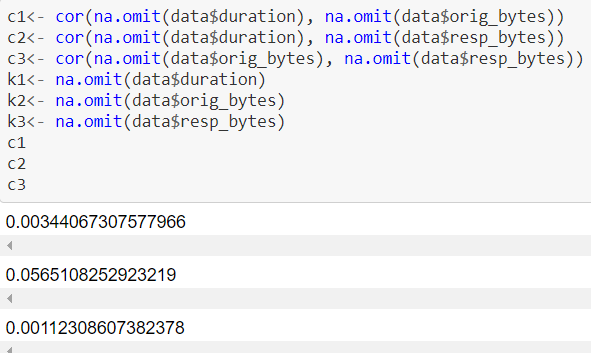

Knowing what the prior correlations between those 3 were, one could check if after applying our reconstructory method the same relations have been preserved to some sensible extent. We expect a good enrichment not to massively disturb the outlook of how these 3 numbers would interact given an algorithm which retains the ordering and scaling somewhat intact. Since we're focusing on correlations, and we've already decided that K-means is expected to perform better due to the observations in stage 1, we make 2 choices:

1) We will have the Mahalanobis metric as the base of our algorithm. This choice is heavily motivated by the covariance matrix captured within the metric, which easily related to the correlation and can be translated as such. This should indicate whether good properties of the relations among the features have been preserved or not by the models.

2) Our default model for testing will be K-means, which we expect to perform well as far as reconstruction is concerned. Therefore, we transcribe the mean values from the K-means model found [in Alex's folder](https://github.com/mc17336/DST-Assessment-2/blob/main/Alex%20Caian/Assessment2%20(1).ipynb) as being:

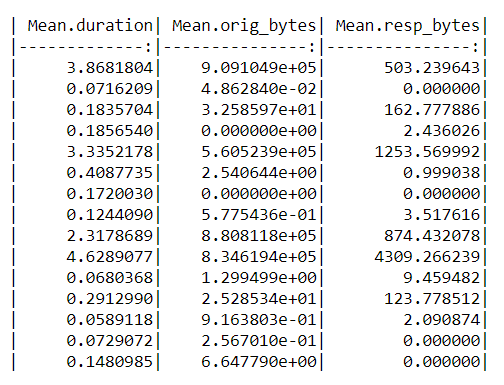

We will refer to those as the default values in our performance analysis, and also use the correlation values we found in the data:

In [7]:
m<- as.vector(c(3.8681804, 0.0716209, 0.1835704, 0.1856540, 3.3352178, 0.4087735, 0.1720030, 
0.1244090, 2.3178689, 4.6289077, 0.0680368, 0.2912990, 0.0589118, 0.0729072, 0.1480985))
n<- as.vector(c(9.091049e+05, 4.862840e-02, 3.258597e+01, 0.000000e+00, 5.605239e+05, 2.540644e+00, 0.000000e+00, 
5.775436e-01, 8.808118e+05, 8.346194e+05, 1.299499e+00, 2.528534e+01, 9.163803e-01, 2.567010e-01, 6.647790e+00))
l<- as.vector(c(503.239643, 0.000000, 162.777886, 2.436026, 1253.569992, 0.999038, 0.000000, 3.517616, 874.432078,
4309.266239, 9.459482, 123.778512, 2.090874, 0.000000, 0.000000))
k1<- 0.05651083
k2<- 0.003440673
k3<- 0.001123086

The algorithm relies on the (3 choose 2) = 3!/2!=3 pairs of features: 'duration'-'orig_bytes' , 'duration'-'resp_bytes' and 'orig_bytes'-'resp_bytes'. These will in turn be studied and compared to their respective correlations: k1,k2 and k3.

**The algorithm:**
1) Compute the Mahalanobis distance for each of the 3 pairs of features.

2) Consider the mean of the obtained values.

3) Store the results.

4) Consider the Euclidian distance between pairs of 2 out of the 3 results, and compare them to the respective distances between pairs of 2 out of the 3 correlation values.

5) Store and evaluate the results.

By step 3, not much is apparent. At step 5, one should begin reasoning the results in light of the provided algorithmic framework. Values of the correlation column should _not_ match the values in the performance column - but they should be related and present a scaling increase or decrease, as to retain the same trend that was present in the data to begin with.

We implement the algorithm:

In [8]:
Performance <- function(mm=m, ll=l, nn=n) {
	ml<- cbind(mm,ll)
	mn<- cbind(mm,nn)
	ln<- cbind(ll,nn)
	c1<-cov(ml)
	c2<-cov(mn)
	c3<-cov(ln)

	perf1<- mahalanobis(ml, center=FALSE,cov=c1, inverted = TRUE)
	perf2<- mahalanobis(mn, center=FALSE,cov=c2, inverted = TRUE)
	perf3<- mahalanobis(ln, center=FALSE,cov=c3, inverted = TRUE)
	p1<- mean(perf1)
	p2<- mean(perf2)
	p3<- mean(perf3)

	Performance_Relations <- rbind(p1,p2,p3)
	Actual_Correlations <- rbind(k1,k2,k3)
	Pa <- as.data.frame(cbind(Performance_Relations, Actual_Correlations))
	names(Pa) <- c("Performance_Relations", "Actual_Correlations")

	p21 <- p2-p1
	p31 <- p3-p1
	p32 <- p3-p2
	k21 <- k2-k1
	k31 <- k3-k1
	k32 <- k3-k2

	Pa.a<- as.data.frame(cbind("Performance_Comparison"=c(p21,p31,p32), "Correlations_Comparison"=-c(k21,k31,k32)))
	print(Pa)
	print(Pa.a)
		}


**0. Alex** We first run it for the K-means model:

In [9]:
Performance()

   Performance_Relations Actual_Correlations
p1          1.787064e+12         0.056510830
p2          2.409931e+22         0.003440673
p3          2.409952e+22         0.001123086
  Performance_Comparison Correlations_Comparison
1           2.409931e+22             0.053070157
2           2.409952e+22             0.055387744
3           2.099432e+17             0.002317587


As one can see, very close values in the correlation comparison are strongly related to arbitrarily close values in the performance_comparison and vice-versa. The 'duration' feature follows a trend of attaining a much stronger correlation with the other 2 features, whereas amongst each other the correlation drops rapidly: On a scale of more than 5 powers in the Performance_Comparison - corresponding to a drop of scale of over 75% in the Correlations_Comparison. This result points to a good performance of the K-means model when it comes to preserving this relevant property.


Let's see how DBScan performs under the same test. 

**1. Matt** For this, we'll need to import Matt's results on the means which can be found [here](https://github.com/mc17336/DST-Assessment-2/blob/main/Matt%20Corrie/mattmeans.csv). If one chooses to replicate the entire process like we do, they are kindly asked to download the .csv file and set their working directory accordingly before running the code:
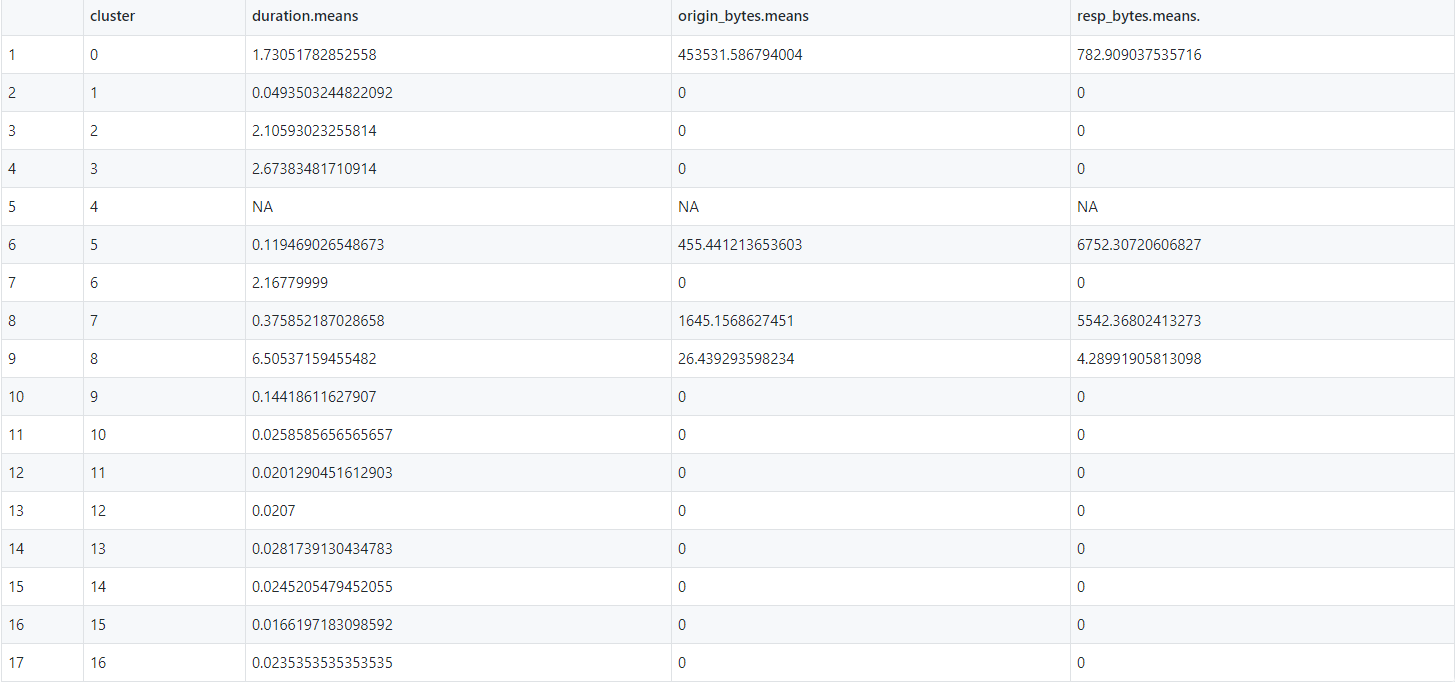

In [10]:
setwd("C://Users//axl_a//Downloads") # Set your own working directory
matt <- read.table(file = "mattmeans.txt", header = T, sep = ",") # If you saved the file as anything else than mattmeans.txt, change so accordingly

We note that row 5 is just NAs, so we'd better remove it beforehand, then proceed with the algorithm:

In [11]:
matt<-matt[-5, ]
matt1 <- matt[,1]
matt2 <- matt[,2]
matt3 <- matt[,3]

The performance of Matt's DBScan is hence as follows:

In [12]:
Performance(matt1,matt2,matt3)

   Performance_Relations Actual_Correlations
p1          1.651698e+20         0.056510830
p2          2.122746e+13         0.003440673
p3          1.651698e+20         0.001123086
  Performance_Comparison Correlations_Comparison
1          -1.651698e+20             0.053070157
2           5.044533e+12             0.055387744
3           1.651698e+20             0.002317587


**2. Wenqi** We'll now view Wenqi's results upon using DBScan, but for fewer clusters (only 14), and with obviously different clusterings. To do that, we'll once again need to import her mean results, which can be found [here](https://github.com/mc17336/DST-Assessment-2/blob/main/Wenqi%20Fang/fwqmeans.csv). The same specifications for the reader apply as in Matt's case above - meaning that the file needs downloading and proper reading in order to review the code. If the reader prefers not to, just like in Matt's case, I'll attach the means below before performing the Performance test:

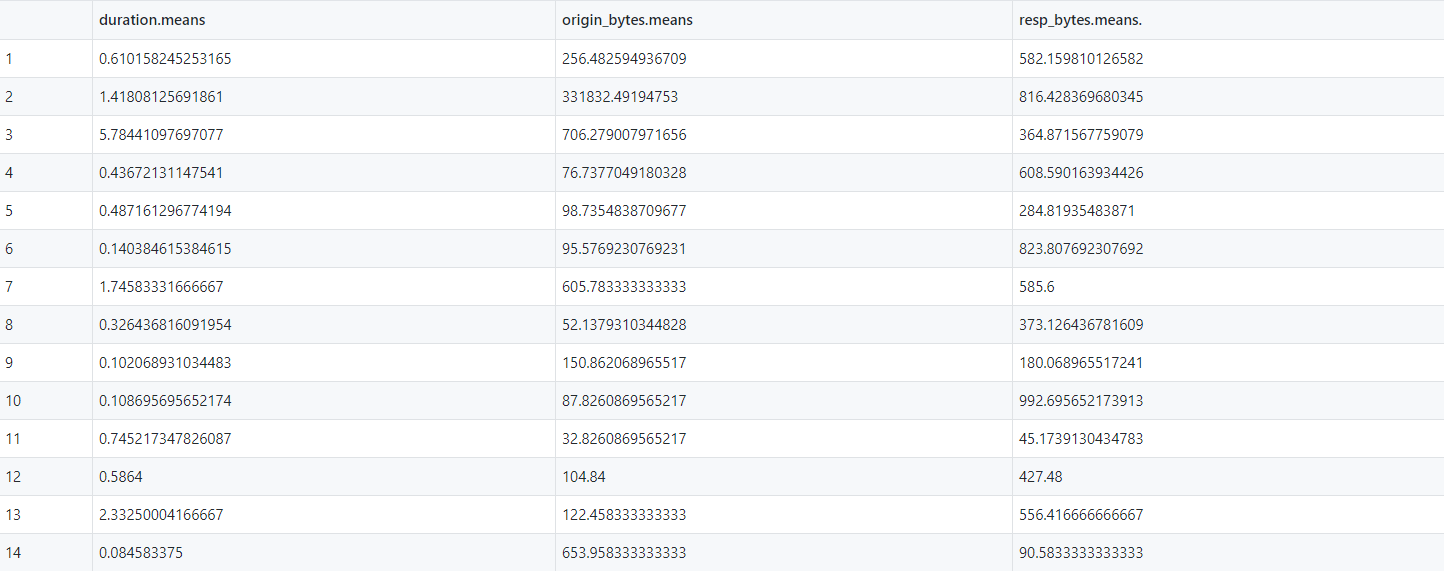

In [13]:
setwd("C://Users//axl_a//Downloads") # Set your own working directory
wenqi <- read.csv(file = "means.csv", header = TRUE) # If you have saved the file as anything else than "means.csv", change so accordingly

In Wenqi's case, the clustering captured no all NA's row - which is an improvement. However, in my reading of the file, Excel added an extra column for counting 1 through 14, which I therefore shall remove. The reader is asked to check whether that's the case for them too before performing the deletion:

In [14]:
wenqi <- wenqi[,-1] # Check if this is necessary for you
wenqi1 <- wenqi[,1]
wenqi2 <- wenqi[,2]
wenqi3 <- wenqi[,3]

And now, we run the performance test:

In [15]:
Performance(wenqi1, wenqi2, wenqi3)

   Performance_Relations Actual_Correlations
p1          6.177534e+19         0.056510830
p2          2.427649e+10         0.003440673
p3          6.177567e+19         0.001123086
  Performance_Comparison Correlations_Comparison
1          -6.177534e+19             0.053070157
2           3.323234e+14             0.055387744
3           6.177567e+19             0.002317587


Although the values obtained by running the Performance() test on Wenqi's means are different from Matt's, a quick inspection will reveal they follow the exact same trends. Hence, we won't treat them separately but instead write a general comparison between K-means and DBScan. If this similarity is not immediately apparent, it should hopefully become so after reading our analysis below:

What we notice in DBScan's case is that the good properties of correlation are lost in the process. The 'duration' feature seems to retain its correlation with one of the other two features in an inverse trend to how the other two features interact amongst themselves. Moreover, most concerning of all is the second row: A slight increase in the correlation comparison from 'k21' to 'k31' is matched with an increase of massive magnitude on the other one, and similarly a sensible decrease from 'k31' to 'k32' does not match what happens in the Performance_Comparison case. This indicates that while 'duration' behaves acceptably well with respect to 'orig_bytes' and 'resp_bytes', they themselves scale an opposite direction from the initial correlation of our data. This was truly to be expected: As we said in Stage 1, DBScan separated all massive outliers in separate clusters and all zero values likewise, which is not the normal behaviour our data seemed to endorse from the previous analysis, nor from the EDA we've been doing in the project as a whole.

We can therefore conclude that, as far as our purpose was that of reconstructing missingness, DBScan performed unexpectedly bad.

## References

All references to the data and results can be found in everyone's individual folders: [Alex's](https://github.com/mc17336/DST-Assessment-2/tree/main/Alex%20Caian) for K-means; [Matt's](https://github.com/mc17336/DST-Assessment-2/tree/main/Matt%20Corrie) and [Wenqi's](https://github.com/mc17336/DST-Assessment-2/tree/main/Wenqi%20Fang) for DBScan.